In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
from transformers import BertTokenizer, BertModel
import numpy as np
import re

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\User\AppData\Local\Progra

In [3]:
df = pd.read_csv('updated_data.csv')

In [4]:
print(df.head())  # Display first few rows
print(df.info())  # Display dataset info (types, nulls, etc.)
print(df.describe())  # Summary statistics

  Corpus                                         Tweet Text  Stance  \
0    EVM  #EVMs are easy to manipulate . This was demons...       1   
1    CAA                    Congratulations\r\nAa gya  #CAA       1   
2    CAA  My dear Indian muslims we are 35 crores of pop...      -1   
3    CAA  This guy was part of anti Hindu protests in th...       1   
4    CAA  Woman protester breaks down while speaking to ...       0   

  Foundation cleaned_tweet  
0   fairness           NaN  
1    loyalty           NaN  
2    loyalty           NaN  
3  authority           NaN  
4       care           NaN  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1228 entries, 0 to 1227
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Corpus         1228 non-null   object
 1   Tweet Text     1228 non-null   object
 2   Stance         1228 non-null   int64 
 3   Foundation     1112 non-null   object
 4   cleaned_tweet  1 non-null     

In [5]:
# Find the number of rows for each unique value in the first column
class_counts = df.iloc[:, 0].value_counts()

# Print the counts for each class
print("Number of rows for each class:")
print(class_counts)

# Print the total number of rows
total_rows = df.shape[0]
print("\nTotal number of rows:", total_rows)


Number of rows for each class:
Corpus
CAA                     207
UCC                     190
EVM                     181
LGBTQ                   173
Animal Sacrifices       166
Anti Conversion Laws    162
Brain Drain             149
Name: count, dtype: int64

Total number of rows: 1228


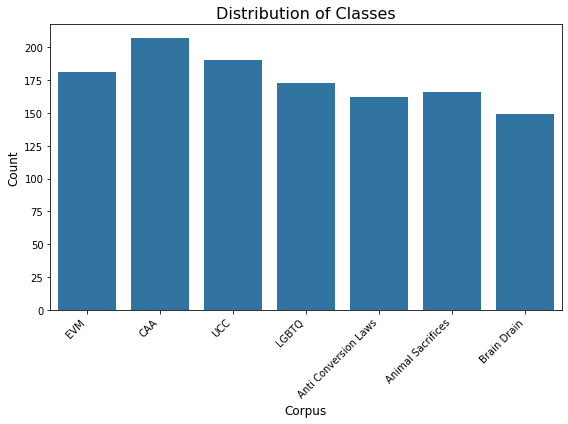

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Corpus', data=df)
plt.title('Distribution of Classes', fontsize=16)
plt.xlabel('Corpus', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

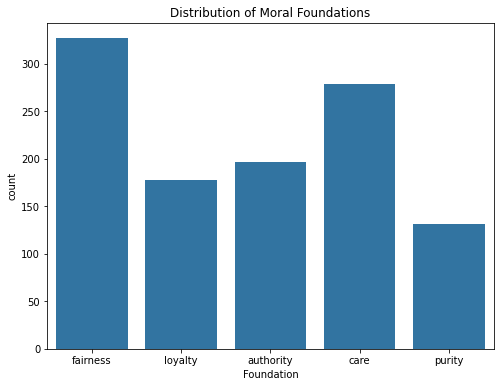

In [7]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Foundation', data=df)
plt.title('Distribution of Moral Foundations')
plt.show()

In [8]:
def clean_tweet(tweet):
    tweet = re.sub(r'@[\w_]+', '', tweet)  # Remove @mentions
    tweet = re.sub(r'#\w+', '', tweet)     # Remove hashtags
    tweet = re.sub(r'http\S+|www\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)  # Remove special characters
    tweet = tweet.strip().lower()  # Strip leading/trailing spaces and lowercase
    return tweet


In [9]:
df['cleaned_tweet'] = df['Tweet Text'].apply(clean_tweet)
#Preprocessing
df = df.dropna()  # Handle missing values

In [1]:
# Label encoding for 'class' and 'foundation' columns
le_class = LabelEncoder()
df['class_encoded'] = le_class.fit_transform(df['Corpus'])


NameError: name 'LabelEncoder' is not defined

In [11]:
#TF-IDF Encoding
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_tweet']).toarray()

In [12]:
#BERT Encoding
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [13]:
def get_bert_embeddings(texts):
    input_ids = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    with torch.no_grad():
        outputs = bert_model(**input_ids)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # [CLS] token embeddings
    return embeddings

In [14]:
X_bert = get_bert_embeddings(df['cleaned_tweet'].tolist())

In [ ]:
# Step 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_bert, y_class, test_size=0.2, random_state=42)

TypeError: Singleton array array(LabelEncoder(), dtype=object) cannot be considered a valid collection.

In [123]:
#Train-Test Split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['class_encoded'], test_size=0.2, random_state=42)
X_train_bert, X_test_bert, _, _ = train_test_split(X_bert, df['class_encoded'], test_size=0.2, random_state=42)

In [124]:
# Step 9: Model Training and Testing with TF-IDF
svm_tfidf = SVC(kernel='linear')
svm_tfidf.fit(X_train_tfidf, y_train)
svm_tfidf_predictions = svm_tfidf.predict(X_test_tfidf)
print("SVM Accuracy with TF-IDF: ", accuracy_score(y_test, svm_tfidf_predictions))

SVM Accuracy with TF-IDF:  0.8430493273542601


In [125]:
log_reg_tfidf = LogisticRegression(max_iter=1000)
log_reg_tfidf.fit(X_train_tfidf, y_train)
log_reg_tfidf_predictions = log_reg_tfidf.predict(X_test_tfidf)
print("Logistic Regression Accuracy with TF-IDF: ", accuracy_score(y_test, log_reg_tfidf_predictions))

Logistic Regression Accuracy with TF-IDF:  0.8385650224215246


In [126]:
# Step 10: Model Training and Testing with BERT
svm_bert = SVC(kernel='linear')
svm_bert.fit(X_train_bert, y_train)
svm_bert_predictions = svm_bert.predict(X_test_bert)
print("SVM Accuracy with BERT: ", accuracy_score(y_test, svm_bert_predictions))

SVM Accuracy with BERT:  0.7309417040358744


In [127]:
log_reg_bert = LogisticRegression(max_iter=1000)
log_reg_bert.fit(X_train_bert, y_train)
log_reg_bert_predictions = log_reg_bert.predict(X_test_bert)
print("Logistic Regression Accuracy with BERT: ", accuracy_score(y_test, log_reg_bert_predictions))

Logistic Regression Accuracy with BERT:  0.7713004484304933


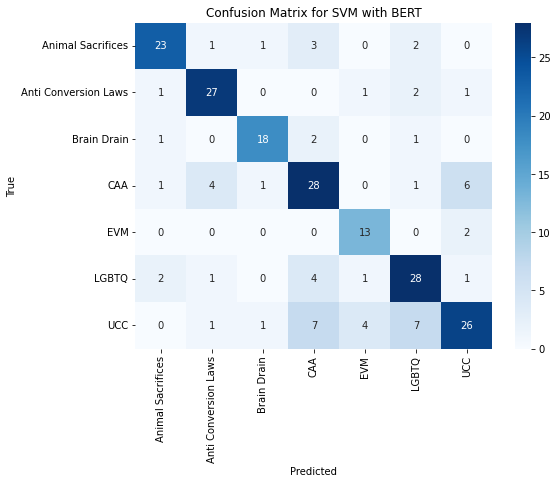

In [128]:
# Step 11: Model Evaluation
# Confusion Matrix for SVM with BERT
cm_bert = confusion_matrix(y_test, svm_bert_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', xticklabels=le_class.classes_, yticklabels=le_class.classes_)
plt.title('Confusion Matrix for SVM with BERT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

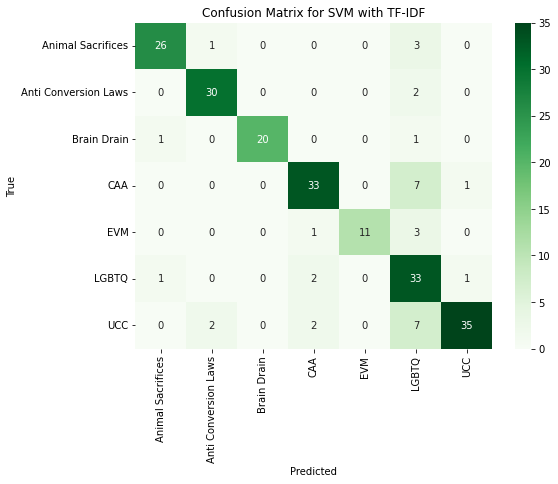

In [129]:
# Confusion Matrix for SVM with TF-IDF
cm_tfidf = confusion_matrix(y_test, svm_tfidf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Greens', xticklabels=le_class.classes_, yticklabels=le_class.classes_)
plt.title('Confusion Matrix for SVM with TF-IDF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [130]:
# Step 12: Cross-Validation
from sklearn.model_selection import cross_val_score

In [131]:
# Cross-validation for SVM with BERT
svm_bert_cv_scores = cross_val_score(svm_bert, X_bert, df['class_encoded'], cv=5)
print(f"SVM Cross-validation scores with BERT: {svm_bert_cv_scores}")

SVM Cross-validation scores with BERT: [0.56053812 0.74439462 0.83333333 0.73873874 0.75675676]


In [132]:
# Cross-validation for SVM with TF-IDF
svm_tfidf_cv_scores = cross_val_score(svm_tfidf, X_tfidf, df['class_encoded'], cv=5)
print(f"SVM Cross-validation scores with TF-IDF: {svm_tfidf_cv_scores}")

SVM Cross-validation scores with TF-IDF: [0.57399103 0.85201794 0.92342342 0.9009009  0.87387387]
